In [1]:
# Importing all the dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [2]:
# Load dataset
df = pd.read_csv("dataset.csv")

In [3]:
df.head()

,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


In [4]:
df.shape

(1002, 17)

In [5]:
df.describe()

,year,price,cylinders,mileage,doors
count,1002.000000,979.000000,897.000000,968.000000,995.000000
mean,2023.916168,50202.985700,4.975474,69.033058,3.943719
std,0.298109,18700.392062,1.392526,507.435745,0.274409
min,2023.000000,0.000000,0.000000,0.000000,2.000000
25%,2024.000000,36600.000000,4.000000,4.000000,4.000000
50%,2024.000000,47165.000000,4.000000,8.000000,4.000000
75%,2024.000000,58919.500000,6.000000,13.000000,4.000000
max,2025.000000,195895.000000,8.000000,9711.000000,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1002 non-null   object 
 1   description     946 non-null    object 
 2   make            1002 non-null   object 
 3   model           1002 non-null   object 
 4   year            1002 non-null   int64  
 5   price           979 non-null    float64
 6   engine          1000 non-null   object 
 7   cylinders       897 non-null    float64
 8   fuel            995 non-null    object 
 9   mileage         968 non-null    float64
 10  transmission    1000 non-null   object 
 11  trim            1001 non-null   object 
 12  body            999 non-null    object 
 13  doors           995 non-null    float64
 14  exterior_color  997 non-null    object 
 15  interior_color  964 non-null    object 
 16  drivetrain      1002 non-null   object 
dtypes: float64(4), int64(1), object(1

In [7]:
df['price'].value_counts()

price
46835.0    13
47340.0    10
28860.0     6
54949.0     5
47785.0     4
           ..
69315.0     1
59037.0     1
69085.0     1
43495.0     1
60904.0     1
Name: count, Length: 859, dtype: int64

In [8]:
# Drop rows with missing target
df_clean = df.dropna(subset=['price'])

In [9]:
# Create new feature: vehicle age
current_year = pd.Timestamp.now().year
df_clean.loc[:, 'vehicle_age'] = current_year - df_clean['year']

C:\Users\HP\AppData\Local\Temp\ipykernel_1964\2296622196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'vehicle_age'] = current_year - df_clean['year']


In [10]:
# Define features and target
features = [
    'make', 'model', 'engine', 'cylinders', 'fuel',
    'mileage', 'transmission', 'trim', 'body', 'doors',
    'exterior_color', 'interior_color', 'drivetrain', 'vehicle_age'
]
target = 'price'
X = df_clean[features]
y = df_clean[target]

In [11]:
# Identify types of columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [12]:
# Pipelines for preprocessing
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [13]:
# Combine into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [14]:
# Full pipeline with Random Forest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Fit the Pipeline model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['cylinders', 'mileage',
                                                   'doors', 'vehicle_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['make', 'model', 'engine',
                                                   'fuel', 'transmission',
                                                   'trim', 'body',
                                                   'exterior_color',
                                                   'interior_color',
                                                   'drivetrain'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [17]:
# Predict
y_pred = model.predict(X_test)

In [18]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) **0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 4647.76
RMSE: 8351.64
R² Score: 0.77


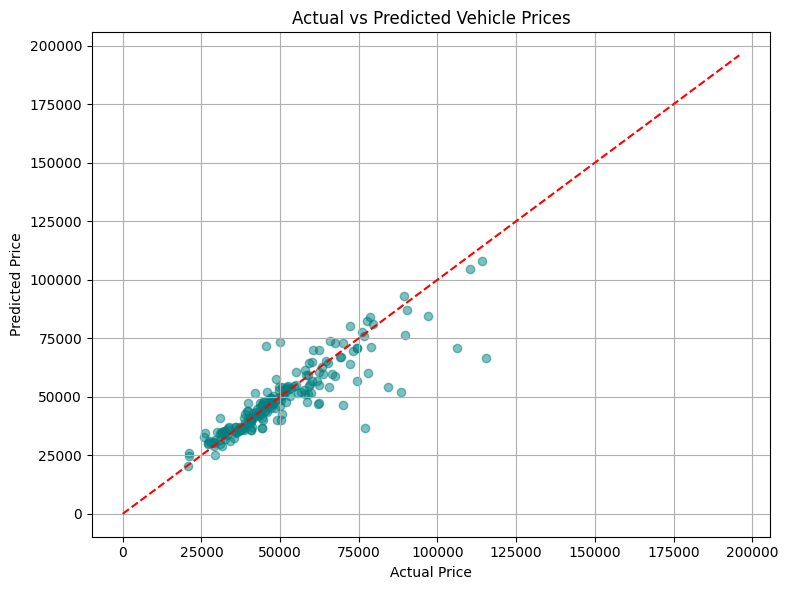

In [19]:
# Visualization 1: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Vehicle Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

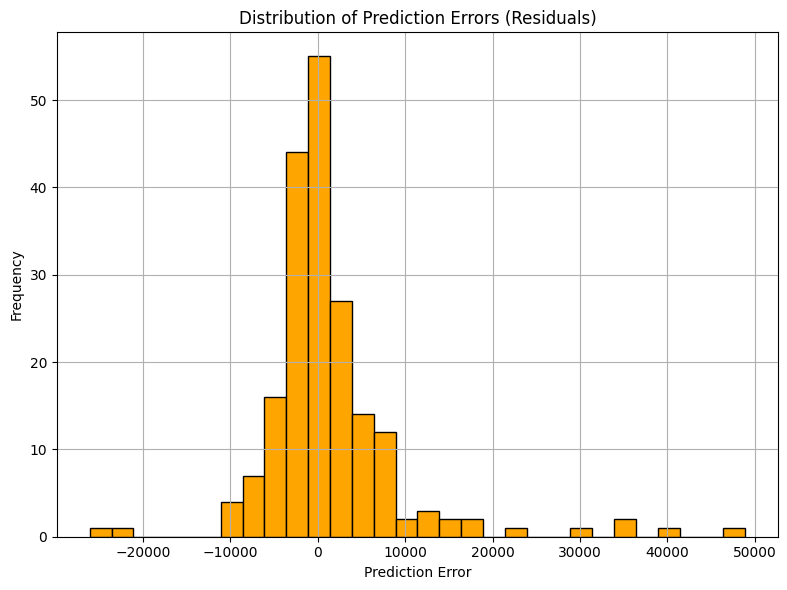

In [20]:
# Visualization 2: Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.grid(True)
plt.tight_layout()
plt.show()

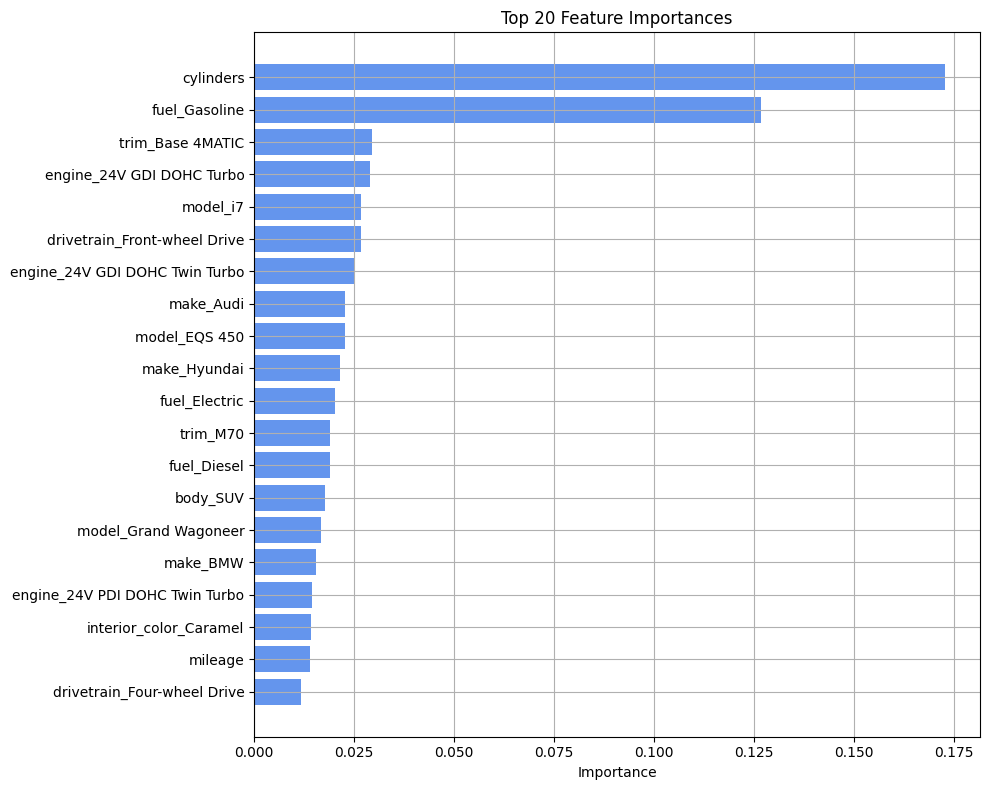

In [21]:
# Visualization 3: Feature Importances
# Get feature names after preprocessing
ohe = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = numerical_cols + cat_features.tolist()

importances = model.named_steps['regressor'].feature_importances_
feat_imp = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp['Feature'], feat_imp['Importance'], color='cornflowerblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Define accuracy as % of predictions within 20% of actual price
tolerance = 0.2
accuracy = np.mean(np.abs((y_test - y_pred) / y_test) < tolerance)

print(f"Custom Accuracy (within ±20% of actual): {accuracy * 100:.2f}%")


Custom Accuracy (within ±20% of actual): 91.33%


In [23]:
# Save the Model Pipeline
import joblib

joblib.dump(model, 'vehicle_price_model.pkl')


['vehicle_price_model.pkl']